*****************************************************
# The Social Web Assignment 4: Recommendation

- Instructors: Davide Ceolin.
- TAs: Jacco van Ossenbruggen, Elena Beretta, Mirthe Dankloff.
- Exercises for Hands-on session 4 
*****************************************************

In this notebook you will use the similarity measures to provide recommendations by comparing users and content based on expressed preferences (ratings). You will also explore textual similarity using a very popular natural language processing library, NLTK. Finally, you will explore recommendations on the Reddit platform.

Required packages:
* feedparser, praw,  nltk

In [3]:
import sys

# !pip install feedparser
# !pip install praw
# !pip install nltk

In the snippets below, you can find:
* creation of a small toy database in form of a dictionary of dictionaries;
* issuing several similarity measures based on critics' preferences; and
* use those values to obtain meaningful statistics pertaining a user.

# Movie preferences of movie critics
As example data, let us define a python dictionary of movie critics and their ratings of a small set of movies


In [4]:
critics = {
    'Lisa Rose': {
        'Lady in the Water': 2.5,
        'Snakes on a Plane': 3.5,
        'Just My Luck': 3.0,
        'Superman Returns': 3.5,
        'You, Me and Dupree': 2.5,
        'The Night Listener': 3.0,
    },
    'Gene Seymour': {
        'Lady in the Water': 3.0,
        'Snakes on a Plane': 3.5,
        'Just My Luck': 1.5,
        'Superman Returns': 5.0,
        'The Night Listener': 3.0,
        'You, Me and Dupree': 3.5,
    },
    'Michael Phillips': {
        'Lady in the Water': 2.5,
        'Snakes on a Plane': 3.0,
        'Superman Returns': 3.5,
        'The Night Listener': 4.0,
    },
    'Claudia Puig': {
        'Snakes on a Plane': 3.5,
        'Just My Luck': 3.0,
        'The Night Listener': 4.5,
        'Superman Returns': 4.0,
        'You, Me and Dupree': 2.5,
    },
    'Mick LaSalle': {
        'Lady in the Water': 3.0,
        'Snakes on a Plane': 4.0,
        'Just My Luck': 2.0,
        'Superman Returns': 3.0,
        'The Night Listener': 3.0,
        'You, Me and Dupree': 2.0,
    },
    'Jack Matthews': {
        'Lady in the Water': 3.0,
        'Snakes on a Plane': 4.0,
        'The Night Listener': 3.0,
        'Superman Returns': 5.0,
        'You, Me and Dupree': 3.5,
    },
    'Toby': {'Snakes on a Plane': 4.5, 
             'You, Me and Dupree': 1.0,
             'Superman Returns': 4.0
    },
    'Amy': {
            'Lady in the Water': 3.0,
            'Snakes on a Plane': 5.0,
            'Superman Returns': 4.0},
}

# **Exercise 1: Finding Similar Users**

In the code below, two different simililarity measures are used: Euclidean distance and the Pearson correlation. If you are not familiar with them, we recommend you look them up to deepen your understanding.

## Euclidian distance

To assess the degree similarity between critics given their respective preferences, we can use the euclidian distance.
Its formula for an N-dimensional space is: 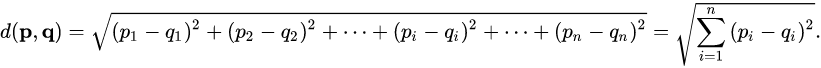
Because we want a smaller distance to indicate a larger similarity, we will use 1/d(p,q) as our similarity value:

In [5]:
from math import sqrt

def sim_distance(p1, p2, show_common_dims=False, prefs=critics):
    '''
    Returns a distance-based similarity score between two critics.
    '''

    # Get the list of shared_items
    common_items = []
    for movie in prefs[p1]:
        if movie in prefs[p2]:
            common_items.append(movie)
    # If they have no ratings in common, return 0
    if len(common_items) == 0:
        return 0
    if show_common_dims:
        print("common dimensions between {} and {}: ".format(p1, p2) + str(len(common_items)))
    # Add up the squares of all the differences
    sum_of_squares = sum([pow(prefs[p1][movie] - prefs[p2][movie], 2) for movie in common_items])
    
    # return sqrt(sum_of_squares)
    return 1 / sqrt(sum_of_squares)

Using this simple formula, you can calculate a similarity between two critics:

In [6]:
# get the distance between 'Lisa Rose' and 'Gene Seymour'
print(sim_distance('Lisa Rose','Gene Seymour'))
print(sim_distance('Amy','Lisa Rose'))

0.41702882811414954
0.6030226891555273


Try this with other names so you can see who is closer or further.

In [7]:
people_cr = ['Lisa Rose', 'Michael Phillips', 'Claudia Puig', 'Mick LaSalle', 'Jack Matthews', 'Toby']

for i in range(5,0,-1):
    for e in range(len(people_cr)-1):
        print(sim_distance(people_cr[i], people_cr[e], show_common_dims=False))

    people_cr.pop()

0.5345224838248488
0.6324555320336759
0.5547001962252291
0.6666666666666666
0.3651483716701107
0.5163977794943222
0.47140452079103173
0.47140452079103173
0.4
0.7071067811865475
0.6324555320336759
0.4588314677411235
0.6324555320336759
1.1547005383792517
0.8944271909999159


Name at least two problems with the sim_distance function as it is defined above. 

Problems:

1. Two users with very different taste are far less likely to watch the same movies, and consequently rate them. As a result, two users may share similar ratings for a few movies, while most other movies they like do not appear on the list of the other user. As a result, the formular indicated they have a similar taste, even though this is certainly not the case.

2. The formular is in no way transitive. If user A and B have a similar taste, according to the formular, and user B and C as well, this does not indicate that user A and C have a similar taste as well. User A and B might share a preference for horror movies, while user B and C both like comedy. B watches both, horror and comedy movies, while A only watched horror, and C only comedy. A and B, as well as B and C have a good match, but A and C have a terrible match as a result.

3. If all common movies of two users have the same rating, the distance becomes 0. As a consequence, the similarity is 1 / 0, which is not defined, resulting in an error.

A different measure of similarity can be given by pearson correlation.
Which follows: 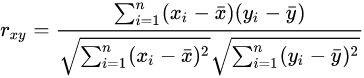

Where the dividend represents a measure of covariance between dimensions, whereas the divisor is the product of the standard deviation of the scores given by each user.

In [8]:
def sim_pearson(p1, p2, prefs=critics, verbose=False):
    '''
    Returns the Pearson correlation coefficient for p1 and p2.
    '''

    '''Step 1: Get the list of mutually rated items'''
    common_items = []
    dic = {}
    for movie in prefs[p1]:
        if movie in prefs[p2]:
            common_items.append(movie)
    # If they are no ratings in common, return 0
    if len(common_items) == 0:
        return 0
    '''Step 2: Sum calculations'''
    n_common_items = len(common_items)
    sum1 = sum([prefs[p1][movie] for movie in common_items])
    sum2 = sum([prefs[p2][movie] for movie in common_items])
    # Sums of squares
    sum1Sq = sum([pow(prefs[p1][movie], 2) for movie in common_items])
    sum2Sq = sum([pow(prefs[p2][movie], 2) for movie in common_items])
    # Sum of the products
    pSum = sum([prefs[p1][movie] * prefs[p2][movie] for movie in common_items])
    # Calculate r (Pearson score)
    num = pSum - sum1 * sum2 / n_common_items
    den = sqrt((sum1Sq - pow(sum1, 2) / n_common_items) * (sum2Sq - pow(sum2, 2) / n_common_items))
    if den == 0:
        return 0
    r = num / den
    if verbose:
        print("common dimensions: %s" % len(common_items))
        print("Similarity Score for {} and {}: {}".format(p1, p2, r))
    return r

# for k in critics.keys():
#     sim_pearson('Michael Phillips', k, verbose=True)

Try the examples you used for the eucledian distance again, but now using the pearson correlation:

In [9]:
print("EXAMPLE 1:\n")

print(sim_pearson('Lisa Rose','Gene Seymour'))
print(sim_pearson('Amy','Lisa Rose'))


print("\nEXAMPLE 2:\n")

people_cr = ['Lisa Rose', 'Michael Phillips', 'Claudia Puig', 'Mick LaSalle', 'Jack Matthews', 'Toby']

for i in range(5,0,-1):
    for e in range(len(people_cr)-1):
        print(sim_distance(people_cr[i], people_cr[e], show_common_dims=False))

    people_cr.pop()

EXAMPLE 1:

0.39605901719066977
0.8660254037844378

EXAMPLE 2:

0.5345224838248488
0.6324555320336759
0.5547001962252291
0.6666666666666666
0.3651483716701107
0.5163977794943222
0.47140452079103173
0.47140452079103173
0.4
0.7071067811865475
0.6324555320336759
0.4588314677411235
0.6324555320336759
1.1547005383792517
0.8944271909999159


### Ranking critics on similarity
The topMatches function below calculates all similarities of a given critic with his peers:

In [10]:
def topMatches(person, n=5, similarity=sim_pearson, prefs=critics):
    '''
    Returns the best matches for person from the prefs dictionary. 
    Number of results and similarity function are optional params.
    '''
    if similarity not in [sim_distance, sim_pearson]:
        # NB: here we are comparing FUNCTION DEFINITION.
        # We do that only in a jupyter notebook for the sake of simplicity.
        raise ValueError("Callback functions should be: 'sim_pearson' or 'sim_distance'.")
        
    scores = [(similarity(person, other, prefs=prefs), other) for other in prefs
              if other != person]
    scores.sort()
    scores.reverse()
    return scores[0:n]

So you can now get the 3 critics closest to Toby by calling:

In [11]:
topMatches('Toby',n=3)

[(1.0, 'Amy'),
 (0.9912407071619299, 'Lisa Rose'),
 (0.9244734516419049, 'Mick LaSalle')]

*****************************************************
### Task: Effect of similarity function used
Call the topMatches function on a number of critics with both the default sim_pearson, but also with the sim_distance function. Would you have preference of one over the other? 
*****************************************************

In [12]:
print("Toby:")
print(f"  Eucledian: {topMatches('Toby',n=5, similarity=sim_distance)}")
print(f"  Pearson:   {topMatches('Toby',n=5)}")

print("\nLisa Rose:")
print(f"  Eucledian: {topMatches('Lisa Rose',n=5, similarity=sim_distance)}")
print(f"  Pearson:   {topMatches('Lisa Rose',n=5)}")

print("\nClaudia Puig:")
print(f"  Eucledian: {topMatches('Claudia Puig',n=5, similarity=sim_distance)}")
print(f"  Pearson:   {topMatches('Claudia Puig',n=5)}")

print("\nAmy:")
print(f"  Eucledian: {topMatches('Amy',n=5, similarity=sim_distance)}")
print(f"  Pearson:   {topMatches('Amy',n=5)}")

Toby:
  Eucledian: [(2.0, 'Amy'), (0.6666666666666666, 'Mick LaSalle'), (0.6324555320336759, 'Michael Phillips'), (0.5547001962252291, 'Claudia Puig'), (0.5345224838248488, 'Lisa Rose')]
  Pearson:   [(1.0, 'Amy'), (0.9912407071619299, 'Lisa Rose'), (0.9244734516419049, 'Mick LaSalle'), (0.8934051474415647, 'Claudia Puig'), (0.66284898035987, 'Jack Matthews')]

Lisa Rose:
  Eucledian: [(0.8944271909999159, 'Michael Phillips'), (0.7071067811865475, 'Mick LaSalle'), (0.6324555320336759, 'Claudia Puig'), (0.6030226891555273, 'Amy'), (0.5345224838248488, 'Toby')]
  Pearson:   [(0.9912407071619299, 'Toby'), (0.8660254037844378, 'Amy'), (0.7470178808339965, 'Jack Matthews'), (0.5940885257860044, 'Mick LaSalle'), (0.5669467095138396, 'Claudia Puig')]

Claudia Puig:
  Eucledian: [(1.1547005383792517, 'Michael Phillips'), (0.6666666666666666, 'Amy'), (0.6324555320336759, 'Lisa Rose'), (0.5547001962252291, 'Toby'), (0.47140452079103173, 'Jack Matthews')]
  Pearson:   [(1.0, 'Michael Phillips'), 

While the Eucledian distance can only ever take positive values, thanks to the squared differences, this is not true for Pearsons measure: It relies on the standard deviation, which can be positive and negative. Consequently, they have to be interpreted differently. However, overall the Eucledian differance seems much simpler to translate into real world meaning. The Pearson correlation might measures a strong dependence, but this correlation may not necessarily translate into a similar taste/rating behaviour: This correlation could also be offset significantly, resulting in a large difference in the actual ratings.

As a consequence, the Pearson measure is only interesting to identify similarities in rating behaviour relative to the mean of all ratings compared. However, if user A prefers comedy, and thus rates all horror movies badly, a user B, who only watched horror, might rate these movies significantly better, but still in a similar order relative to each other. In this case, the Pearson correlation between A and B would still be large, even though the ratings itself, and thus their taste is not.

Depending on the requirements, either measure might be useful though: If we are interested in the quality rating of movies relative to each other, we would prefer the Pearson correlation. If we are interested in the actual ratings, and thus opinions of two users, then the Eucledian distance.

### **Exercise 2: Recommending Items**

One way to recommend movies to a person would be to rate the movies she has not seen yet by using the scores of the others weighted by the similarity.

In [13]:
def getRecommendations(person, similarity=sim_pearson, prefs=critics):
    '''
    Gets recommendations for a person by using a weighted average
    of every other user's rankings
    '''
    if similarity not in [sim_distance, sim_pearson]:
        raise ValueError("Callback functions should be: 'sim_pearson' or 'sim_distance'.")

    totals = {}
    simSums = {}
    for other in prefs:
    # Don't compare me to myself
        if other == person:
            continue
        sim = similarity(person, other, prefs=prefs)
    # Ignore scores of zero or lower
        if sim <= 0: 
            continue
        for item in prefs[other]:
            # Only score movies I haven't seen yet
            if item not in prefs[person] or prefs[person][item] == 0:
                # Similarity * Score
                    totals.setdefault(item, 0)
                    # The final score is calculated by multiplying each item by the
                    #   similarity and adding these products together
                    totals[item] += prefs[other][item] * sim
                    # Sum of similarities
                    simSums.setdefault(item, 0)
                    simSums[item] += sim
    # Create the normalized list
    rankings = [(total / simSums[item], item) for (item, total) in
                totals.items()]
    # Return the sorted list
    rankings.sort()
    rankings.reverse()
    return rankings

In [14]:
getRecommendations('Toby', similarity=sim_distance)

[(3.4721701369256524, 'The Night Listener'),
 (2.8716745911876562, 'Lady in the Water'),
 (2.4349456273856207, 'Just My Luck')]

In [15]:
getRecommendations('Toby')


[(3.3477895267131017, 'The Night Listener'),
 (2.8748373260264186, 'Lady in the Water'),
 (2.530980703765565, 'Just My Luck')]

Note that the output does not only consist of a movie title, but also a guess at what the user's rating for each movie would be.

*****************************************************
### Task: Explainable recommendations
Can you also find out how to give information on how the recommendation is built up. For example about the 'closest' person that also watched this movie?
*****************************************************

For this task, we will extract the best recommendations, as well as the closest critic to a user. Now, we search for the movie with the highest recommendation, that is also rated by the closest critic. This movie is likely to fit to the user's taste, and we can advertise it as "liked by your closest critic".

In [16]:
# Get the ratings for the recommended movies from the closest person
ranking = getRecommendations('Toby')
matches = topMatches('Toby')

movies = [item for (rank, item) in ranking]
close_critics = [critic for (rank, critic) in matches]

closest_critic = critics[close_critics[0]]

movies_closest_critic = closest_critic.keys()
ratings_closest_critic = closest_critic.values()

closest_critic_ratings = []

for movie in movies:
    if movie in movies_closest_critic:
        closest_critic_ratings.append((movie, closest_critic[movie]))


print(f'Recommendations based on your closest critic {close_critics[0]}:')
for title, rating in closest_critic_ratings:
    print(f'  -> {title}, rated {rating} by them!')

Recommendations based on your closest critic Amy:
  -> Lady in the Water, rated 3.0 by them!


### **Exercise 3: Transformations** 
**You have been building recommendations based on similar users in Exercise 2, but you could of course also build recommendations based on similar items. In this exercise you will do this.** 

The function is essentially the same, but you need to transfer your data, from:

<code>{'Lisa Rose': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5},
'Gene Seymour': {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5}}</code>

to

<code>{'Lady in the Water': {'Lisa Rose': 2.5,'Gene Seymour': 3.0},
'Snakes on a Plane': {'Lisa Rose': 3.5,'Gene Seymour': 3.5}}</code>

This is what the transformPrefs function does. 

You can now create a dictionary for movies with their scores assigned by different people by invoking:

In [17]:
def transformPrefs(prefs=critics):
    '''
    Transform the recommendations into a mapping where persons are described
    with interest scores for a given title e.g. {title: person} instead of
    {person: title}.
    '''
    result = {}
    for person in prefs:
        for item in prefs[person]:
            result.setdefault(item, {})
            # Flip item and person
            result[item][person] = prefs[person][item]
    return result

In [18]:
movies = transformPrefs()
print(movies)

{'Lady in the Water': {'Lisa Rose': 2.5, 'Gene Seymour': 3.0, 'Michael Phillips': 2.5, 'Mick LaSalle': 3.0, 'Jack Matthews': 3.0, 'Amy': 3.0}, 'Snakes on a Plane': {'Lisa Rose': 3.5, 'Gene Seymour': 3.5, 'Michael Phillips': 3.0, 'Claudia Puig': 3.5, 'Mick LaSalle': 4.0, 'Jack Matthews': 4.0, 'Toby': 4.5, 'Amy': 5.0}, 'Just My Luck': {'Lisa Rose': 3.0, 'Gene Seymour': 1.5, 'Claudia Puig': 3.0, 'Mick LaSalle': 2.0}, 'Superman Returns': {'Lisa Rose': 3.5, 'Gene Seymour': 5.0, 'Michael Phillips': 3.5, 'Claudia Puig': 4.0, 'Mick LaSalle': 3.0, 'Jack Matthews': 5.0, 'Toby': 4.0, 'Amy': 4.0}, 'You, Me and Dupree': {'Lisa Rose': 2.5, 'Gene Seymour': 3.5, 'Claudia Puig': 2.5, 'Mick LaSalle': 2.0, 'Jack Matthews': 3.5, 'Toby': 1.0}, 'The Night Listener': {'Lisa Rose': 3.0, 'Gene Seymour': 3.0, 'Michael Phillips': 4.0, 'Claudia Puig': 4.5, 'Mick LaSalle': 3.0, 'Jack Matthews': 3.0}}


And find similar items for a particular movie like this:

In [19]:
topMatches('Superman Returns', prefs=movies)

[(0.6579516949597695, 'You, Me and Dupree'),
 (0.46291004988627404, 'Lady in the Water'),
 (0.07881104062391006, 'Snakes on a Plane'),
 (-0.1798471947990544, 'The Night Listener'),
 (-0.42289003161103106, 'Just My Luck')]

Or find people who may like a particular movie:

In [20]:
getRecommendations('Just My Luck', prefs=movies)

[(4.0, 'Michael Phillips'), (3.0, 'Jack Matthews')]

*****************************************************
#### Task: why does the example above work?
Try to follow exactly what is going on in the last call. Notice that Michael and Jack did not rate 'Just my Luck'. How is their rating for it built up?
*****************************************************

Instead of calculating which movies would fit to an input user, we start with a movie. For this input movie, we check how similar each other movie is. Now, we can test how each user rated these movies. We sum up all these ratings for each user, weighted by the similarity a movie has to the input movie. This way, ratings for movies more similar to the input movie have a stronger impact on the final result, as it is more likely that those ratings can be translate to the input movie.

The result is a dictionary, mapping for each user how they would likely rate the input movie. By sorting these according to the predicted rating, we get the users that are most likely to like the input movie. All resulting users will hereby not have watched the movie yet, as we filter out those users previously.

### **Exercise 4: Sentence Similarity**

In [21]:
# import natural language processing software we need later.
import nltk
from nltk.stem import WordNetLemmatizer


In [22]:
# Download wordnet and punkt sentence tokenizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to C:\Users\Maximilian
[nltk_data]     Mayer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Maximilian
[nltk_data]     Mayer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Maximilian
[nltk_data]     Mayer\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Below we have some example sentences to compare later on.

In [23]:
movies = ["I saw a really good movie last night.",
"The movie is based on the director's life.",
"The movie starts at ten.",
"I took her to a movie.",
"The movie stars Al Pacino.",
"The movie opened last weekend.",
"The movie lasted two hours.",
"He directed several movies.", 
"We just shot another movie.", 
"The movie was set in New York."]

In [24]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

To get the Jaccard Similarity of two sentences however, we first need to do some preprocessing in the form of Lemmatization and Tokenization.

In [25]:
def compare(s1, s2):

    #Import a Lemmatizer to get the root form of certain words
    lemmatizer = WordNetLemmatizer() 
    
    #Tokenize both sentences to get each word separately
    word_list1 = nltk.word_tokenize(s1)
    word_list2 = nltk.word_tokenize(s2)
    
#     print("Tokenized sentence", word_list1) #Uncomment to see an example of the tokenized sentence 
    
    #Lemmatize both sentences
    lemmatized_output1 = ' '.join([lemmatizer.lemmatize(w, 'v') for w in word_list1])
    lemmatized_output2 = ' '.join([lemmatizer.lemmatize(w, 'v') for w in word_list2])
    
    return lemmatized_output1, lemmatized_output2

In [26]:
from nltk.stem import WordNetLemmatizer
for x in range(len(movies)):
    l1, l2 = compare(movies[0], movies[x])
    print("Sentence 1:", l1, '\n', "Sentence 2:", l2, '\n', "Similarity Score:", get_jaccard_sim(l1,l2), "\n")

Sentence 1: I saw a really good movie last night . 
 Sentence 2: I saw a really good movie last night . 
 Similarity Score: 1.0 

Sentence 1: I saw a really good movie last night . 
 Sentence 2: The movie be base on the director 's life . 
 Similarity Score: 0.11764705882352941 

Sentence 1: I saw a really good movie last night . 
 Sentence 2: The movie start at ten . 
 Similarity Score: 0.15384615384615385 

Sentence 1: I saw a really good movie last night . 
 Sentence 2: I take her to a movie . 
 Similarity Score: 0.3333333333333333 

Sentence 1: I saw a really good movie last night . 
 Sentence 2: The movie star Al Pacino . 
 Similarity Score: 0.15384615384615385 

Sentence 1: I saw a really good movie last night . 
 Sentence 2: The movie open last weekend . 
 Similarity Score: 0.25 

Sentence 1: I saw a really good movie last night . 
 Sentence 2: The movie last two hours . 
 Similarity Score: 0.25 

Sentence 1: I saw a really good movie last night . 
 Sentence 2: He direct several

*****************************************************
#### Task: In what scenario's could the Jaccard Similarity be more useful than the Euclidean distance and the Pearson Similarity metrics? Why is that? 
*****************************************************

In the context of movie recommendations, the Jaccard Similarity could be used to recommend movies with similar titles, or, if a description of the movie is available, movies with a similar description. Alternatively, it could be used to recommend movies based on a given query. A critic could, for example, provide a number of words they would like to see in a movie's description, and the movie with the greatest similarity between description and these search terms could be recommended.

In more general terms, it is hard to compare the Eucledian distance or the Pearson Similarity to the Jaccard Similarity, as the latter operates on words, while the other two use numbers. Consequently, every recommendation or comparison of text, sentences, or words would require the Jaccard Similarity. However, in turn it would be rather useless, or at least complicated to use in combination with ratings, as we did previously.

In conclusion, while all three methods calculate some form of similarity, they are designed for very different contexts.

### **Exercise 5: Building a Reddit Recommender**

After having created your Reddit account, go to User Settings -> Safety & Privacy -> Manage third-party app authorization.
Here, you will create your own app. Give it a name, and add "https://www.reddit.com/prefs/apps/" to the redirect uri. Keep the other settings as they are.
You may encounter some issues accessing "https://www.reddit.com/prefs/apps/" in Chrome. If so, try with another browser.

* replace the '???' in the user_agent string with your name (or any unique string).
* replace the '???' in the client_id with the id right underneath your web app name.
* replace the '???' in the client_secret with the key next to 'secret'.

NOTE: install praw v. 3.5 


In [27]:
# -*- coding: utf-8 -*-

import praw
import time

#Delete keys before handing in the notebook
r = praw.Reddit(user_agent='xantocxx', 
                client_id='HRlw289OL306ni3U-w3Cng',
                client_secret='SVoSSTOpaZirKGTUmgBILs7HpTbXTw',
                redirect_url='https://www.reddit.com/prefs/apps/'
                             'authorize_callback')


def initializeUserDict(subreddit, count=10):
    user_dict={}
    # get the top count' popular posts
    for post in r.subreddit(subreddit).top(limit=count):
        # find all users who commented in this
        flat_comments = post.comments.list()
        for comment in flat_comments:
            try:
                user = comment.author.name
                user_dict[user] = {}
            except AttributeError:
                pass
    return user_dict

def fillItems(user_dict, count=100):
    all_items={}
    # Find links posted by all users
    for user in user_dict:
        # print("finding subreddits where user " + user + "has commented")
        # find new comments for given user
        comments = r.redditor(user).comments.new(limit=count)
        for c in comments:
            # Get the subreddit where the comment was made
            subreddit = c.subreddit
            sub_name = subreddit.display_name
            # print(sub_name)
            if sub_name in user_dict[user]:
                user_dict[user][sub_name] += 1.0
            else:
                user_dict[user][sub_name] = 1.0
            
            all_items[sub_name] = 1
#     Fill in missing items with 0
#     for subr_counts in user_dict.values():
#         for item in all_items:
#             if item not in subr_counts:
#                 subr_counts[item]=0.0
    
    return user_dict

def fillComments(user_dict, count=100):
    all_items={}
    # Find links posted by all users
    for user in user_dict:
        # print("finding subreddits where user " + user + "has commented")
        # find new comments for given user
        comments = r.redditor(user).comments.new(limit=count)
        for c in comments:
            # Get the subreddit where the comment was made
            post = c.submission
            post_name = post.name
            # print(sub_name)
            if post_name in user_dict[user]:
                user_dict[user][post_name] += 1.0
            else:
                user_dict[user][post_name] = 1.0
            
            all_items[post_name] = 1
#     Fill in missing items with 0
#     for subr_counts in user_dict.values():
#         for item in all_items:
#             if item not in subr_counts:
#                 subr_counts[item]=0.0
    
    return user_dict

 

You can get a list of popular recent posts about programming from the programming subreddit (https://www.reddit.com/r/VUAmsterdam) by invoking the code below.  Don't forget to replace the '???' in the user_agent string with your name (or any unique string).

In [28]:
print("praw version == " + praw.__version__)

# subreddit = r.subreddit("programming")
for post in r.subreddit('VUAmsterdam').top(limit=5):
     print(end='\n * ')
     print(post.title)


praw version == 7.6.1

 * Opinions on Political Science: Global Politics

 * Menta Health Well-being at the VU

 * Coronavirus at the VU

 * Got accepted into cs program last year, but now it’s numerous fixus

 * Improving the subreddit


See here a list of other subreddits you can explore with this code: https://www.reddit.com/reddits/

To automatically create a data set of reddit users similar to the movie watchers you can invoke the initializeUserDict function in redditrec.py 

In [29]:
red_users=initializeUserDict('VUAmsterdam', count=15) # or for any other subreddit
print(red_users)

{'Digesta94': {}, 'CrazyRide72': {}, 'SenseiTrade': {}, 'BillHoudini': {}, 'angulardragon03': {}, '-BYeBYe-': {}, 'visvis': {}, 'samsungebluckburry': {}, 'PlantBeanVibes': {}, 'schuifdurrrr': {}, 'reks_rb': {}, 'No-Trip-3464': {}, 'Any_Watercress7798': {}, 'cariimejia16': {}, 'ElkNo1598': {}, 'Adorable_Suggestion4': {}, 'PawBud': {}, 'DomDom2002': {}, 'aitahb': {}, 'DigProgrammatically3': {}, 'aythida': {}, 'rexygorl': {}, 'redmehalis': {}, 'Otherwise_Extreme_59': {}, 'wassup5551': {}, 'deepshitgoeshere': {}, 'These-Psychology-959': {}, 'macedoineGontran': {}, 'Thenextelonmusklol': {}, 'nfp267': {}, 'amaxs': {}, 'ImAClosetNerd': {}, 'Agreeable_Baseball87': {}, 'whocares4817': {}, 'Administrative_Fun_6': {}}


Now initializeUserDict has only created the user keys. We of course also want to know what subreddits they posted comments on. You can pull those in through:

In [30]:
fillItems(red_users, count=15)
# here you can see how often each user commented in what sub.

{'Digesta94': {'VUAmsterdam': 1.0},
 'CrazyRide72': {'StudyInTheNetherlands': 9.0,
  'VUAmsterdam': 3.0,
  'Denmark': 1.0,
  'Advice': 1.0,
  'MDMA': 1.0},
 'SenseiTrade': {'VUAmsterdam': 2.0,
  'FreeKarma4You': 1.0,
  'FitnessMaterialHeaven': 1.0,
  'AskReddit': 2.0,
  'overcominggravity': 3.0,
  'LifeProTips': 1.0,
  'bodyweightfitness': 1.0,
  'powerlifting': 2.0,
  'weightlifting': 2.0},
 'BillHoudini': {'tennis': 7.0,
  'europe': 1.0,
  'TechnoProduction': 1.0,
  'soccer': 1.0,
  'progmetal': 1.0,
  'DunderMifflin': 1.0,
  'footballmanagergames': 1.0,
  'Barca': 1.0,
  'Beatmatch': 1.0},
 'angulardragon03': {'VUAmsterdam': 10.0,
  'StudyInTheNetherlands': 1.0,
  'swift': 2.0,
  'apple': 1.0,
  'technology': 1.0},
 '-BYeBYe-': {'Windows10': 1.0,
  'Liverpool': 4.0,
  'Pixel6': 1.0,
  'AskReddit': 6.0,
  'VUAmsterdam': 1.0,
  'JoblessReincarnation': 1.0,
  'Minecraft': 1.0},
 'visvis': {'thenetherlands': 9.0,
  'StudyInTheNetherlands': 3.0,
  'Music': 2.0,
  'europe': 1.0},
 'samsun

This script may take a few minutes to collect all the data. Use this time to review what is going on in the code. Notice that users don't give ratings to subreddits, instead we are counting how many comments they posted in each subreddit. 

To recommend a similar user, we can use our topMatches function again.

First choose a random user for whom you're going to find neighbours

In [31]:
import random
user= random.choice( list( red_users.keys() ))
print (user) # print the username 
topMatches(user, prefs=red_users) # from all redditors, get the most similar to user

No-Trip-3464


[(1.0, 'reks_rb'),
 (1.0, 'Administrative_Fun_6'),
 (0, 'whocares4817'),
 (0, 'wassup5551'),
 (0, 'visvis')]

If no similar user was found, you can try increasing the count of users or comments for each initializeUserDict and fillItems.

*****************************************************
#### Task: Recommend subreddits for a user based on what subreddits similar users have commented in. Recommend posts for a user based on posts they have commented on. 
*****************************************************

In [114]:
def socialRecommendations(chosen_user, user_items, max_number=5):
    # from all redditors, get the most similar to user
    # we use pearson similarity, as we do not care about the overall number of comments made, but a general trend of similarity
    similar_users = {user: similarity for similarity, user in topMatches(chosen_user, n=5, prefs=user_items)}

    # get bes subreddit recommendations based on other users' preferences
    best_subreddits = {subreddit: rating for rating, subreddit in getRecommendations(chosen_user, prefs=user_items)}

    print(f"Selected User:\n{chosen_user}\n")
    print(f"Similar Users:\n{similar_users}\n")
    print(f"Most Fitting Items based on other Users' Preferences:\n{best_subreddits}\n")

    # find all subreddits used by similar users and check how much they would fit for our user based on their similarity to that user
    recommended_subreddits = {}
    for user, similarity in similar_users.items():
        for subreddit, rating in user_items[user].items():
            if subreddit in user_items[chosen_user]: continue
            recommended_subreddits.setdefault(subreddit, 0)
            recommended_subreddits[subreddit] += similarity * rating

    # sort recommendations
    recommended_subreddits = dict(reversed(sorted(recommended_subreddits.items(), key=lambda item: item[1])))

    print(f"Recommended Items based on Similar Users:\n{recommended_subreddits}\n")

    # list of all subreddits that may be recommended
    all_recommended_subreddits = set(list(best_subreddits.keys()) + list(recommended_subreddits.keys()))

    # merge both recommendations
    final_recommendations = {}
    for subreddit in all_recommended_subreddits:
        best_subreddits.setdefault(subreddit, 0)
        recommended_subreddits.setdefault(subreddit, 0)

        # We weight the best_recommendations higher, as they are the optimal recommendations for this user, while recommended_subreddits only contains the best options
        # that were found within the list of similar users. However, that list may contain multiple users with similarity 0, and is thus not as reliable.
        final_recommendations[subreddit] = (3 * best_subreddits[subreddit] + 2 * recommended_subreddits[subreddit]) / 5

    # sort recommendations and limit to top 5
    recommendation_count = min(max_number, len(final_recommendations))
    final_recommendations = dict(list(reversed(sorted(final_recommendations.items(), key=lambda item: item[1])))[:recommendation_count])

    print(f"Best Combined Recommendation:\n{final_recommendations}")

    return final_recommendations

In [115]:
from random import choice

# BEST SUBREDDITS RECOMMENDATION

# setup users array with data
OVERWRITE = False
if red_users is None or OVERWRITE:
    users = initializeUserDict('VUAmsterdam', count=30) 
    fillItems(users, count=30)
else:
    users = red_users

# choose user with at least one other similar user(s) with similarity > 0
# this is not necessary, but ensures that we can make any recommendations based on preference using the getRecommendations method, and is thus more interesting
while True:

    # select random user
    chosen_user = choice(list(users.keys()))

    # from all redditors, get the most similar to user
    # we use pearson similarity, as we do not care about the overall number of comments made, but a general trend of similarity
    similar_users = {user: similarity for similarity, user in topMatches(chosen_user, n=5, prefs=users)}

    # check if any similarity value to the found users is larger than 0
    if any(similarity > 0 for similarity in similar_users.values()):
        break

recommendations = socialRecommendations(chosen_user, users)

Selected User:
Thenextelonmusklol

Similar Users:
{'wassup5551': 1.0, 'cariimejia16': 1.0, 'aitahb': 1.0, 'These-Psychology-959': 1.0, 'Otherwise_Extreme_59': 1.0}

Most Fitting Items based on other Users' Preferences:
{'tumunich': 6.0, 'Amsterdam': 5.0, 'Kanye': 4.0, 'TUe': 3.0, 'NoFap': 3.0, 'TUDelft': 2.0, 'sysadmin': 1.0, 'space': 1.0, 'nginx': 1.0, 'gradadmissions': 1.0, 'django': 1.0, 'PostgreSQL': 1.0, 'MDMA': 1.0, 'Laptop': 1.0, 'HealthAnxiety': 1.0, 'Futurology': 1.0, 'Denmark': 1.0, 'AskReddit': 1.0, 'Advice': 1.0}

Recommended Items based on Similar Users:
{'tumunich': 6.0, 'Amsterdam': 5.0, 'Kanye': 4.0, 'TUe': 3.0, 'NoFap': 3.0, 'TUDelft': 2.0, 'Futurology': 1.0, 'space': 1.0, 'gradadmissions': 1.0, 'sysadmin': 1.0, 'django': 1.0, 'nginx': 1.0, 'PostgreSQL': 1.0, 'AskReddit': 1.0, 'HealthAnxiety': 1.0, 'Laptop': 1.0}

Best Combined Recommendation:
{'tumunich': 6.0, 'Amsterdam': 5.0, 'Kanye': 4.0, 'NoFap': 3.0, 'TUe': 3.0}


In [90]:
# read comments for users, cached so we can reuse the data when modifying the following cells
submissions = initializeUserDict('VUAmsterdam', count=15) 
fillComments(submissions, count=15)
print(submissions)

{'Digesta94': {'t3_yfohi6': 1.0}, 'CrazyRide72': {'t3_yvznih': 2.0, 't3_yvr3so': 1.0, 't3_yflph6': 1.0, 't3_yfohi6': 2.0, 't3_yepjzg': 7.0, 't3_y3qitw': 1.0, 't3_xfx6c4': 1.0}, 'SenseiTrade': {'t3_yfohi6': 1.0, 't3_xfvx2w': 1.0, 't3_ugu62f': 1.0, 't3_wqrimu': 1.0, 't3_wkdua9': 1.0, 't3_whyrub': 1.0, 't3_w8i9kw': 1.0, 't3_w2p2dm': 1.0, 't3_t70amu': 1.0, 't3_sz2hr9': 1.0, 't3_sthcx5': 1.0, 't3_mv1rn0': 2.0, 't3_pf9mi6': 2.0}, 'BillHoudini': {'t3_z1bd2t': 1.0, 't3_z0cgcd': 1.0, 't3_ys1ge2': 1.0, 't3_y6hbb8': 1.0, 't3_y5mi3k': 1.0, 't3_xzvvt7': 1.0, 't3_xt4tzt': 1.0, 't3_xrqzm7': 1.0, 't3_xpe2gh': 1.0, 't3_xnv7gp': 1.0, 't3_xlhmdv': 2.0, 't3_xjex9m': 1.0, 't3_xewl7n': 1.0, 't3_x7h3j3': 1.0}, 'angulardragon03': {'t3_z0wcf0': 1.0, 't3_yvpwaf': 1.0, 't3_y7n5ci': 1.0, 't3_y1z3ya': 1.0, 't3_xw6lan': 2.0, 't3_xtsjm6': 1.0, 't3_xg4c8t': 2.0, 't3_x79pz4': 3.0, 't3_x8wkae': 1.0, 't3_w5z1ro': 1.0, 't3_wwm5en': 1.0}, '-BYeBYe-': {'t3_z3nc13': 1.0, 't3_w2oqpf': 2.0, 't3_w1qiw4': 1.0, 't3_w0o5n7': 1.0,

In [91]:
# extract titles to submissions from above
submission_titles = {}

for _, user_submissions in submissions.items():
    for submission in user_submissions:
        submission_titles[submission] = praw.models.Submission(r, id=submission[3:]).title

print(submission_titles)

{'t3_yfohi6': 'Got accepted into cs program last year, but now it’s numerous fixus', 't3_yvznih': 'Periods in Vrije Universiteit semester?', 't3_yvr3so': 'Masters admissions', 't3_yflph6': 'Studying in Aarhus as an international student', 't3_yepjzg': 'Should I study in Amsterdam or Leiden?', 't3_y3qitw': 'Study abroad full-time or keep studying in my country?', 't3_xfx6c4': 'If you take less than 0.15 does the 3 month rule still apply?', 't3_xfvx2w': 'KARMA 4 KARMA I WILL GIVE BACK INSTANTLY FOR NEXT 2 HOURS', 't3_ugu62f': 'Ian Barseagle calisthenics program', 't3_wqrimu': '[deleted by user]', 't3_wkdua9': 'Adding weight vs reps', 't3_whyrub': 'LPT: When you gave in to unhealthy food craving, immediately record a video of yourself talking about how you feel about it. Say whether it was worth it or not. Next time you feel a craving watch the recorded video, so you can make a better decision based on rationality and not temporary feelings.', 't3_w8i9kw': 'Very confused', 't3_w2p2dm': 'M

In [113]:
# RECOMMENDING POSTS SIMILAR TO POSTS A USER COMMENTED ON

# choose user with at least one other similar user(s) with no comments on posts that were deleted
# this is not necessary, but ensures that we don't only recommend deleted posts, as all deleted posts have the same text: [deleted by user]
while True:

    # select random user
    chosen_user = choice(list(users.keys()))

    # get all submissions the user commented on
    user_submissions = set(submissions[chosen_user].keys())

    # check all posts are still available and were not deleted
    if not any(submission_titles[submission] == "[deleted by user]" for submission in user_submissions):
        break

# get all submissions any user commented on
submissions_ids = set()
for _, ids in submissions.items():
    for id in ids:
        submissions_ids.add(id)

# get all submissions any user but not the chosen user commented on
other_submissions = submissions_ids.difference(user_submissions)

# claculate similarity of submission titles based on Jaccard Similarity to the posts the chosen user commented on, and return the maximum similarity
def user_submission_similarity(submission):
    ratings = []
    for user_submission in user_submissions:
        l1, l2 = compare(submission_titles[submission], submission_titles[user_submission])
        ratings.append(get_jaccard_sim(l1,l2))
    return max(ratings)

# map all submissions to their similarity with any of the users submissions
rated_submissions = {submission: user_submission_similarity(submission) for submission in other_submissions}
# sort submissions by rating
final_recommendations = dict(list(reversed(sorted(rated_submissions.items(), key=lambda item: item[1])))[:5])

print(f"Posts Similar to Posts the User '{chosen_user}' commented on:")
for submission, rating in final_recommendations.items():
    print(f"\t{submission_titles[submission]} (Similarity: {rating})")

# Recommend posts for user based on what posts similar users have commennted on
#red_users = initializeUserDict('VUAmsterdam', count=15) 
#fillComments(red_users, count=15)
#print(getRecommendations(user, prefs=red_users))

Posts Similar to Posts the User Otherwise_Extreme_59 commented on:
	Computer Science at VU Amsterdam (Similarity: 0.8)
	Master after BSc Computer Science @VU (Similarity: 0.375)
	CS Curriculum at VU (Similarity: 0.3333333333333333)
	International students at VU (Similarity: 0.3333333333333333)
	Question about Computer Science programs. (Similarity: 0.25)
